In [11]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math


In [2]:
model_name = "model_large"
img_width = 200
img_height = 66
img_channels = 3
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)


In [3]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

if not os.path.isfile(dataset_zipfile):
    default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
    print ("No existing dataset. download from ", default_dataset_URL)
    r = requests.get(default_dataset_URL)
    open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

in colab


No existing dataset. download from  https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip
unzip Dataset.zip into dataset folder


In [4]:
from keras import layers

model = tf.keras.Sequential()
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

In [5]:
# Train/test data lists
imgs = []
vals = []

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)

    vid = cv2.VideoCapture(vid_file_path)
    ret,img = vid.read()
    while(ret):
        # Convert to grayscale and readd channel dimension
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_width, img_height))
            img = np.reshape(img, (img_height, img_width, img_channels))
        # For RGB, just need to resize image
        else:
            img = cv2.resize(img, (img_width, img_height))
        img = img / 255.
        imgs.append(img)
        ret,img = vid.read()
    df = read_csv(csv_file_path)
    temp = np.asarray(df["wheel"].values)
    vals.extend(temp)
    # print(len(imgs), len(vals))    

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video.avi dataset/out-key.csv
Loaded 1000 smaples


In [6]:
# Split the dataset for train and test 
print("Train/Test")
le = preprocessing.LabelEncoder()
vals = le.fit_transform(vals)
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

Train/Test


In [9]:
#print(x_train[0])
print ("Model compile")
optimizer = tf.keras.optimizers.Adam(1e-4)
if os.path.isfile(model_file+".h5"):
    model = tf.keras.models.load_model(model_file+".h5")
    optimizer = optimizer=tf.keras.optimizers.Adam(5e-5)
model.compile(optimizer=optimizer,
                loss='mse', metrics=['mae'])
model.summary()

Model compile
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)  

Model fit
Epoch 1/10
8/8 [==============================] - 9s 918ms/step - loss: 0.1820 - mae: 0.3702 - val_loss: 0.1514 - val_mae: 0.3564
Epoch 2/10
8/8 [==============================] - 5s 603ms/step - loss: 0.1773 - mae: 0.3428 - val_loss: 0.1609 - val_mae: 0.3820
Epoch 3/10
8/8 [==============================] - 5s 605ms/step - loss: 0.1752 - mae: 0.3865 - val_loss: 0.1350 - val_mae: 0.2662
Epoch 4/10
8/8 [==============================] - 5s 604ms/step - loss: 0.1654 - mae: 0.3315 - val_loss: 0.1471 - val_mae: 0.3529
Epoch 5/10
8/8 [==============================] - 5s 598ms/step - loss: 0.1584 - mae: 0.3315 - val_loss: 0.1281 - val_mae: 0.2778
Epoch 6/10
8/8 [==============================] - 5s 610ms/step - loss: 0.1511 - mae: 0.3237 - val_loss: 0.1284 - val_mae: 0.2875
Epoch 7/10
8/8 [==============================] - 5s 685ms/step - loss: 0.1478 - mae: 0.3132 - val_loss: 0.1254 - val_mae: 0.2519
Epoch 8/10
8/8 [==============================] - 6s 729ms/step - loss: 0.1473 -

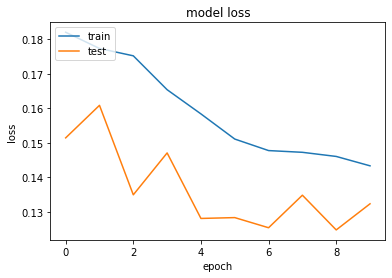

In [10]:
print ("Model fit")
history = model.fit(x_train, y_train, batch_size=100,
                    epochs=10, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
def get_action(label):
  if label < 0.5:
    return "left"
  elif label >= 0.5 and label <= 1.5:
    return "center"
  elif label > 1.5:
    return "right"

In [15]:
pred = model.predict(x_test)
pred = np.array(list(map(get_action, pred)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))
print(classification_report(pred, ground))

Accuracy is 0.812
              precision    recall  f1-score   support

      center       0.89      0.88      0.88       203
        left       0.50      0.51      0.51        47

    accuracy                           0.81       250
   macro avg       0.69      0.70      0.69       250
weighted avg       0.81      0.81      0.81       250



In [16]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
INFO:tensorflow:Assets written to: /tmp/tmp4jtcy_n0/assets


models/large-200x66x3.tflite is saved. copy this file to the robot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>